In [1]:
params_notebook_name = "parnet.predictions.py.ipynb"
params_resource_dir = "../resources/"

# PARNET - predictions

## Imports

In [196]:
import functools
import inspect
import os
import random
import sys
from pathlib import Path

import h5py
import logomaker as lm
import numpy as np
import pandas as pd
import parnet
import parnet.additional_utils
import parnet.utils
import torch
import yaml
from captum.attr import DeepLift, FeatureAblation, GradientShap, IntegratedGradients, NoiseTunnel
from dotenv import find_dotenv, load_dotenv

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def assert_notebook_working_dir(expected_local_file: os.PathLike) -> Path:
    """Assert or try updating the current working directory to where the notebook is located, to enable relative paths references.

    This function is used in a set-up where notebooks are contained within a project
    directory structure in which we want to reference filepaths relative to the notebook.
    e.g. "../src" or "../resources" should be accessible if the notebook is in
    "../notebooks/<notebook_name>.ipynb".

    The function first check the filepath of the expected local file relative
    to the current working directory.

    If not found, the function will try to use the VSCode Jupyter variable `__vsc_ipynb_file__`
    which should report the path of the notebook file being executed.

    It then checks if the expected local file exists, relative to the new working directory.


    Args:
        expected_local_file (os.PathLike): The expected local file to check for in the current working directory.
            This can be the name of the notebook file.

    Raises:
        KeyError: if the `__vsc_ipynb_file__` variable is not found in the global scope, while the first CWD check failed.
        FileNotFoundError: if the expected local file is not found in the current working directory after attempting to change it.
    """
    import os
    from pathlib import Path

    cwd = Path(os.getcwd())
    expected_local_filepath = cwd / expected_local_file

    if not expected_local_filepath.exists():
        if "__vsc_ipynb_file__" not in globals():
            raise KeyError(
                f"Detected CWD: {cwd} ; CWD does not contain expected file, but cannot use __vsc_ipynb_file__ to recover."
            )
        else:
            os.chdir(Path(globals()["__vsc_ipynb_file__"]).parent)
            cwd = Path(os.getcwd())
            print(f"Changed CWD to {cwd}")

            expected_local_filepath = cwd / expected_local_file
            if not expected_local_filepath.exists():
                raise FileNotFoundError(
                    f"Updated (using __vsc_ipynb_file__) CWD: {cwd} ; CWD does not contain expected file."
                )

            return cwd
    else:
        print(f"Confirmed CWD: {cwd} contains expected file: {expected_local_file}")
        return cwd


expected_local_file: str = params_notebook_name
cwd = assert_notebook_working_dir(expected_local_file=expected_local_file)
print(cwd)

Confirmed CWD: /home/l10n/projects/ml4rg25-parnet/parnet_demo/notebooks contains expected file: parnet.predictions.py.ipynb
/home/l10n/projects/ml4rg25-parnet/parnet_demo/notebooks


## Initialization

In [5]:
# Env variables, defined in the `.env` file at the root of the project directory.
load_dotenv(find_dotenv(), override=True)

False

In [6]:
resource_dir = Path(params_resource_dir)
if not resource_dir.exists():
    raise FileNotFoundError("Resource directory does not exist: " + str(resource_dir))

print("Using resources from:", resource_dir)

Using resources from: ../resources


## Load

In [7]:
with open(resource_dir / "parnet_models" / "config.parnet_models.yaml") as f:
    config_models = yaml.safe_load(f)

display(config_models["models"])

{'parnet_21m': {'blob_metadata': '21M parameters, 2024-11-26',
  'is_old_model': True,
  'is_penalized': False,
  'identifier_model_weights': 'parnet.21m-none',
  'identifier_table_of_tasks': 'full_rbp_set'},
 'parnet_7m_p0.0': {'blob_metadata': 'penalized model, 7M parameters, 2025-01-10 ; official Github distribution parnet v0.3.0',
  'is_old_model': False,
  'is_penalized': True,
  'penalty': 0.0,
  'softmax_output': ['total', 'target', 'control'],
  'identifier_model_weights': 'parnet.7m-0.0',
  'identifier_table_of_tasks': 'full_rbp_set'},
 'parnet_7m_p2.5': {'blob_metadata': 'penalized model, 7M parameters, penalty of 2.5, 2025-01-10',
  'is_old_model': False,
  'is_penalized': True,
  'penalty': 2.5,
  'softmax_output': ['total', 'target', 'control'],
  'path_model_weights': 'parnet.7m-p2.5',
  'path_table_of_tasks': 'full_rbp_set'}}

PARNET is still in development, so while different pretrained models are available,
some of the parameters have been changed.

Notably the `parnet_21m` model is missing some elements, and is thus labelled as an "old" model.

On the other end, the newer 7 million parameters models are up-to-date with respect to the 
code in the PARNET repository.



What this means is that the 7 million parameters models are likely to be usable for both 
fine-tuning and inference, while the 21 million parameters model is only usable for inference.

To help with working with any of the models, we provide a `load_model` function to load the model for inference.


In [8]:
print(inspect.getsource(parnet.additional_utils.load_parnet_model_for_prediction))

def load_parnet_model_for_prediction(
    model_weigth_path: os.PathLike,
    device: torch.device,
    dtype: torch.dtype,
    is_old_model: bool = False,
) -> RBPNet:
    """Load a parnet model for prediction."""
    model = torch.load(
        model_weigth_path,
        map_location=device,
        weights_only=False,
    ).to(dtype)

    # disable dropout for deterministic results
    model.eval()

    # Parnet is still under heavy dev. and some "older" models are lacking
    # components in their architectures. For prediction it is enough to
    # simply set these components to None.
    if is_old_model:
        model.projection = None
        model.head.control_nograd = False


    return model



In [9]:
filepaths = {
    "parnet.21m-none": resource_dir / "parnet_models" / "parnet.21m-non.pt",
    "parnet.7m-0.0": resource_dir / "parnet_models" / "parnet.7m-0.0.pt",
    "parnet.7m-2.5": resource_dir / "parnet_models" / "parnet.7m-2.5.pt",
    "full_rbp_set": resource_dir / "parnet_models" / "full_rbp_set.tsv",
}

In [229]:
selected_parnet_model = "parnet_7m_p0.0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16
filepath_selected_model = filepaths[config_models["models"][selected_parnet_model]["identifier_model_weights"]]

parnet_model = parnet.additional_utils.load_parnet_model_for_prediction(
    model_weigth_path=filepath_selected_model,
    device=device,
    dtype=dtype,
    is_old_model=config_models["models"][selected_parnet_model]["is_old_model"],
)


In [11]:
parnet.additional_utils.print_basic_info_parnet_model(
    model=parnet_model,
    device=device,
    dtype=dtype,
)

Number of trainable parameters: 7_534_815
Available output data:  dict_keys(['target', 'control', 'total', 'mix_coeff', 'penalty_loss'])


/home/l10n/projects/ml4rg25-parnet/parnet_demo/.pixi/envs/parnet-demo-gpu/lib/python3.10/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730827426462/work/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


In [12]:
parnet_tracks_table = pd.read_csv(filepaths["full_rbp_set"], header=0, index_col=None, sep="\t")
display(parnet_tracks_table.head(10))
print("Number of tracks in the table:", len(parnet_tracks_table))

,rbp_ct,rbp,ct
0,AARS_K562,AARS,K562
1,AATF_K562,AATF,K562
2,ABCF1_K562,ABCF1,K562
3,AGGF1_HepG2,AGGF1,HepG2
4,AGGF1_K562,AGGF1,K562
5,AKAP1_HepG2,AKAP1,HepG2
6,AKAP1_K562,AKAP1,K562
7,AKAP8L_K562,AKAP8L,K562
8,APOBEC3C_K562,APOBEC3C,K562
9,AQR_HepG2,AQR,HepG2


Number of tracks in the table: 223


In [13]:
# NOTE: the parnet model is composed of three parts: `stem`, `body`, and `head`.
# We can create a model that produces the embedding vectors by omitting the `head` part.

parnet_model_embedding = torch.nn.Sequential(*[parnet_model.stem, parnet_model.body])
parnet_model_embedding = parnet_model_embedding.to(device=device, dtype=dtype)


## Demonstration

### Sequence

Here we build a mock sequence with the "QKI" motif in the center.

QKI is an RBP that has a very well defined sequence motif, and usually shows very sharp
binding profiles.

NOTE: most models have been trained to predict the binding profiles over 600 nucleotides windows,
so here we also demonstrate that the prediction task can be done over larger sequences.

(and of course the sequence can be shorter than 600 nucleotides, without the need for padding)

In [96]:
# IMPORTANT: The alphabet should be "ACGT" even though we manipulate RNA sequences.

known_motif = "TACTAACATT"

# Build a sequence with 500 randomly sampled nucleotides upstream and downstream of the motif.

# mock_sequence = (
#    random.choices(population=["A", "C", "G", "T"], k=500)
#    + list(qki_motif)
#    + random.choices(population=["A", "C", "G", "T"], k=500)
# )
# mock_sequence = "".join(mock_sequence)

# Simplify even more: only "A" before and after the qki_motif
mock_sequence = "A" * 500 + known_motif + "A" * 500


print("Mock sequence length:", len(mock_sequence))

Mock sequence length: 1010


### Embeddings

In [97]:
with torch.no_grad():
    seq_onehot = torch.stack([parnet.utils.sequence_to_onehot(mock_sequence).float()]).to(device=device, dtype=dtype)
    embeddings = parnet_model_embedding(seq_onehot)

    # Move back to CPU.
    embeddings = embeddings.detach().cpu().numpy()

In [98]:
# The embeddings are a numerical representation of each of the position in the sequence.
# This can be useful for e.g. comparing the impact of a mutation on the representation of the
# mutated position in the sequence (the higher functional impact, the more different the representation),
# or to compare the average representation of two different sequences, e.g. two genes, or two
# peaks of a different RBPs.

# dim = N_ITEM x N_DIM x N_POSITIONS
display(embeddings.shape)

(1, 512, 1010)

Embeddings are the numerical features that the model has learned to represent the sequence.

They can be used for downstream tasks such as clustering, visualization, or as input features for other models.

They can also be used directly to explore the sequence space, comparing the embeddings of different sequences.

Hereafter we demonstrate this by inducing mutations in the sequence, and observing how the embeddings change,
through the cosine similarity.

In [99]:
# Here: we mutate the sequence by replacing the central nucleotide with its complement.

complement_nucleotide = {
    "A": "T",
    "C": "G",
    "G": "C",
    "T": "A",
}

mutated_sequence = list(mock_sequence)
mutated_sequence[len(mutated_sequence) // 2] = complement_nucleotide[mutated_sequence[len(mutated_sequence) // 2]]
mutated_sequence = "".join(mutated_sequence)

with torch.no_grad():
    seq_onehot = torch.stack([parnet.utils.sequence_to_onehot(mutated_sequence).float()]).to(device=device, dtype=dtype)
    mut_embeddings = parnet_model_embedding(seq_onehot)

    # Move back to CPU.
    mut_embeddings = mut_embeddings.detach().cpu().numpy()

print(mut_embeddings.shape)


(1, 512, 1010)


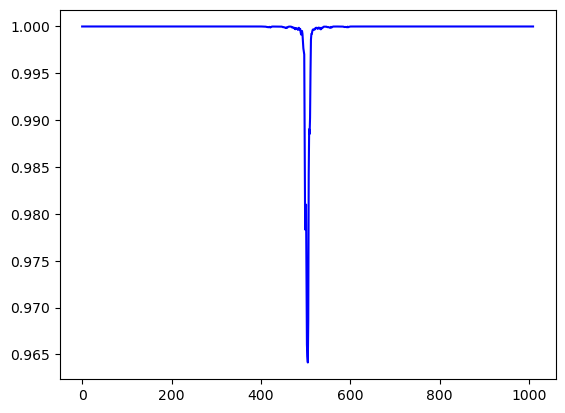

In [100]:
# We can now calculate the cosine similarity between the original and mutated embeddings at each position.
# This can be interpreted as a measure of how much the mutation has changed the representation of the sequence at each position.

per_pos_cosinesim = torch.nn.functional.cosine_similarity(
    torch.Tensor(embeddings[0, :, :]), torch.Tensor(mut_embeddings[0, :, :]), dim=0
)

# This should show a great decrease at the central position, representing that the numerical representation of the
# mutation has changed significantly.

plt.plot(
    per_pos_cosinesim,
    label="Cosine similarity between original and mutated embeddings",
    color="blue",
)


### Profile predictions

In [101]:
with torch.no_grad():
    seq_onehot = torch.stack([parnet.utils.sequence_to_onehot(mock_sequence).float()]).to(device=device, dtype=dtype)
    predictions = parnet_model({"sequence": seq_onehot})

    # Apply softmax transformation if needed, as per the config file.
    for k in config_models["models"][selected_parnet_model].get("softmax_output", []):
        if k == "mix_coeff":
            dim = 1
        elif k in ["target", "control", "total"]:
            dim = 2
        else:
            raise ValueError(f"Unknown key {k} for softmax transformation.")
        predictions[k] = torch.nn.functional.softmax(predictions[k], dim=dim)

    # Move back to CPU.
    predictions = {k: v.detach().cpu().numpy() for k, v in predictions.items()}


In [102]:
predictions.keys()

dict_keys(['target', 'control', 'total', 'mix_coeff', 'penalty_loss'])

Explanation of the prediction keys:

- `total`: the predicted eCLIP profile, calculated as a composition of the "cleaned" `target` and `control` profile.
- `control`: the predicted profile for the control "input" signal (corresponding to the experimental measurements where the protein was "glued" to the RNA, but then all RNAs sequences were sequenced, rather than retrieved only the protein-bound ones).
- `target` : the "cleaned" predicted profile for the RBP binding.
- `mix_coef` : the predicted weight associated to the `target` signal when combining the `target` and `control` profiles to get the `total` profile. The higher, the more "high-quality" the signal is.
- `penalty_loss`: additional penalty parameter applied to the `mix_coef`.


In [103]:
# dim = N_ITEM x N_EXPERIMENTS x N_POSITIONS
predictions["target"].shape

(1, 223, 1010)

(1010,)


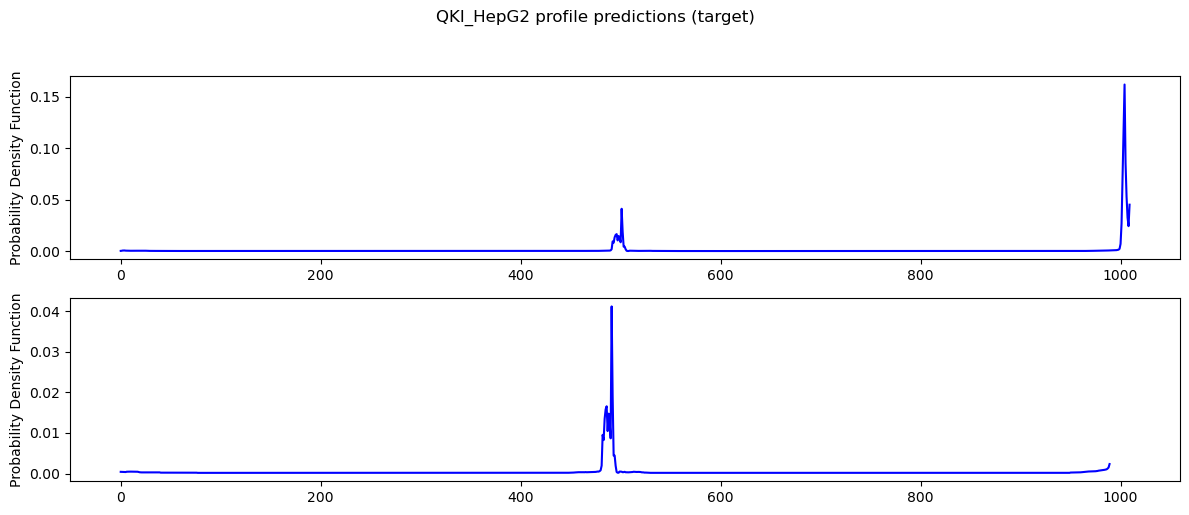

In [122]:
# We will plot the profile for the QKI_HepG2 experiment.

# First: retrieve the index of the QKI_HepG2 experiment.
candidate_rbp_ct = "QKI_HepG2"
selected_track = "target"

index_predictions_candidate_rbp_ct = parnet_tracks_table.loc[lambda df: df["rbp_ct"] == candidate_rbp_ct].index[0]

# Now: extract the prediction profile for the QKI_HepG2 experiment.
# Here: we extract the "cleaned" `target` profile.
predictions_selected = predictions[selected_track][0, index_predictions_candidate_rbp_ct, :]

print(predictions_selected.shape)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(predictions_selected, label=candidate_rbp_ct, color="blue")
ax1.set_ylabel("Probability Density Function")

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

ax2.plot(predictions_selected[10:-10], label=candidate_rbp_ct, color="blue")
ax2.set_ylabel("Probability Density Function")

plt.suptitle(f"{candidate_rbp_ct} profile predictions ({selected_track})", y=1.02)

plt.tight_layout(rect=[0, 0, 1, 0.98])


NOTE: as seen above, some profiles show "border effects" at the beginning or the end of any sequence.

So for interpretation, you could decide to ignore the first and last 10% of nucleotides in the profiles.

### Feature importance - from the profile

In [ ]:
feature_importance_df = pd.get_dummies(list(mock_sequence)).astype(int)
feature_importance_df = feature_importance_df * predictions_selected[:, None]

for base in ["A", "C", "G", "T"]:
    if base not in feature_importance_df.columns:
        feature_importance_df[base] = 0
feature_importance_df = feature_importance_df.loc[:, ["A", "C", "G", "T"]].replace(np.nan, 0)

display(feature_importance_df.head(10))

,A,C,G,T
0,0.000310,0.0,0,0.0
1,0.000421,0.0,0,0.0
2,0.000647,0.0,0,0.0
3,0.000716,0.0,0,0.0
4,0.000684,0.0,0,0.0
5,0.000528,0.0,0,0.0
6,0.000485,0.0,0,0.0
7,0.000514,0.0,0,0.0
8,0.000487,0.0,0,0.0
9,0.000423,0.0,0,0.0


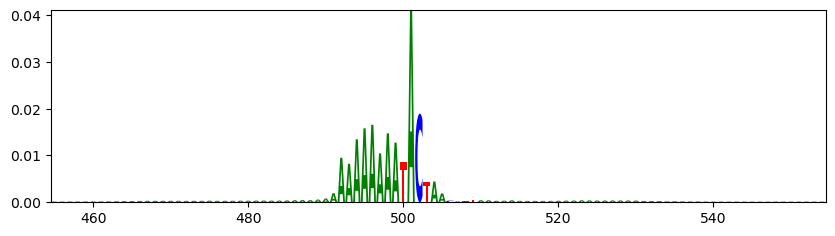

In [ ]:
center_pos = len(mock_sequence) // 2
start = center_pos - 50
end = center_pos + 50

nn_logo = lm.Logo(feature_importance_df.iloc[start:end, :])

### Feature importance - using Captum

NOTE: here using the `IntegratedGradients` method from Captum, but you can check NoiseTunnel, DeepLift, GradientShap, or FeatureAblation.

In [233]:
def model_wrapper(
    input_tensor: torch.Tensor,
    model: torch.nn.Module,
    task_index: int,
    output_key: str = "target",
    softmax_output: bool = True,
    softmax_output_dim: int = 2,
) -> torch.Tensor:
    input_dict = {"sequence": input_tensor}

    outputs = model(input_dict)
    outputs_elem = outputs[output_key]
    if softmax_output:
        dim = softmax_output_dim
        outputs_elem = torch.nn.functional.softmax(outputs_elem, dim=dim)

    return outputs_elem[:, task_index, :]


In [242]:
# NOTE: using float16 seems to fail for some methods???
dtype = torch.float16


parametrized_model_wrapper = functools.partial(
    model_wrapper,
    model=parnet_model.to(device=device, dtype=dtype),
    task_index=int(index_predictions_candidate_rbp_ct),
    output_key="target",
    softmax_output=True,
    softmax_output_dim=2,
)

ig = IntegratedGradients(parametrized_model_wrapper)

# Initialize attribution methods
ig = IntegratedGradients(parametrized_model_wrapper)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(parametrized_model_wrapper)
gs = GradientShap(parametrized_model_wrapper)
fa = FeatureAblation(parametrized_model_wrapper)

methods = {"IntegratedGradients": ig, "NoiseTunnel": ig_nt, "DeepLift": dl, "GradientShap": gs, "FeatureAblation": fa}

########################################################################

seq_onehot = torch.stack([parnet.utils.sequence_to_onehot(mock_sequence).float()]).to(device=device, dtype=dtype)
input_data = {"sequence": seq_onehot}

# Define baseline (e.g., all zeros)
baseline = torch.zeros_like(seq_onehot).to(device=device, dtype=dtype)

selected_method = "IntegratedGradients"
method = methods[selected_method]


# NOW: we will iterate over all the positions over length L, to calculate the contribution from all nucleotide positions
# to each output position.
# We will then be able to calculate the mean

attributions_all = []
for i in range(len(mock_sequence)):
    if i % 200 == 0:
        print(i)

    # TODO: verify with Andreina whether baselines make sense.
    if selected_method == "GradientShap" or selected_method in ["DeepLift", "IntegratedGradients"]:
        attr, delta = method.attribute(inputs=seq_onehot, baselines=baseline, target=i, return_convergence_delta=True)

    else:
        attr, delta = method.attribute(inputs=seq_onehot, target=i, return_convergence_delta=True)

    attributions_all.append(attr)

# Stack results: shape [L, batch, channels, sequence_length]
# First dimension : we assessed for each position in the OUTPUT how much each nucleotide position
# in the INPUT contributed to the output.
attributions_all = torch.stack(attributions_all)

print(f"{attributions_all.shape=}")

0
200
400
600
800
1000
attributions_all.shape=torch.Size([1010, 1, 4, 1010])


In [243]:
# average over L outputs → shape [1, 4, sequence_length]
mean_attr = attributions_all.mean(dim=0)
print(f"{mean_attr.shape=}")

# Drop the "one-hot-encoding" 4 channels dimension ; only keep one score per position.
pos_importance = mean_attr.sum(dim=1)
print(f"{pos_importance.shape=}")

# Since we have only one sequence, we can drop the batch dimension.
pos_importance = pos_importance.squeeze(0)
print(f"{pos_importance.shape=}")

# Detach and move to CPU
pos_importance = pos_importance.detach().cpu().numpy()

mean_attr.shape=torch.Size([1, 4, 1010])
pos_importance.shape=torch.Size([1, 1010])
pos_importance.shape=torch.Size([1010])


In [244]:
feature_importance_df = pd.get_dummies(list(mock_sequence)).astype(int)
feature_importance_df = feature_importance_df * pos_importance[:, None]

for base in ["A", "C", "G", "T"]:
    if base not in feature_importance_df.columns:
        feature_importance_df[base] = 0
feature_importance_df = feature_importance_df.loc[:, ["A", "C", "G", "T"]].replace(np.nan, 0)

display(feature_importance_df.head(10))

,A,C,G,T
0,0.000001,0.0,0,0.0
1,0.000002,0.0,0,0.0
2,0.000002,0.0,0,0.0
3,0.000003,0.0,0,0.0
4,0.000002,0.0,0,0.0
5,0.000002,0.0,0,0.0
6,0.000002,0.0,0,0.0
7,0.000002,0.0,0,0.0
8,0.000002,0.0,0,0.0
9,0.000002,0.0,0,0.0


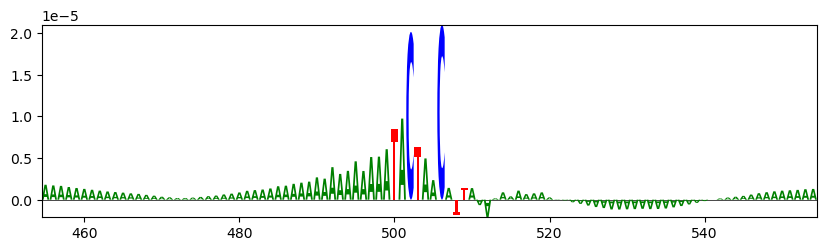

In [245]:
center_pos = len(mock_sequence) // 2
start = center_pos - 50
end = center_pos + 50

nn_logo = lm.Logo(feature_importance_df.iloc[start:end, :])